# MAGIC

In this notebook, we use molecular cross-validation to find the optimal set of hyperparameters for the MAGIC algorithm on a dataset from

*David van Dijk, et al. Recovering Gene Interactions from Single-Cell Data Using Data Diffusion. 2018. Cell.*

We find that the optimal parameters produce a much less smooth picture of the relationship between three genes, *CDH1, VIM, ZEB1* than the default parameters do, indicating the importance of calibrating denoising methods.

In [1]:
import numpy as np
import scanpy as sc
from util import normalize_rows, mse

from sklearn.utils.extmath import randomized_svd
import magic
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
magic.__version__

'1.5.5'

In [3]:
data = sc.read('../../../HMLE_TGFb_day_8_10.csv.gz')

In [4]:
import altair as alt

In [5]:
sc.pp.filter_cells(data, min_counts=1000)
sc.pp.filter_genes(data, min_cells=10)
data.X = data.X.astype(np.int)

In [6]:
x1 = np.random.binomial(data.X, 0.5)
x2 = data.X - x1

In [7]:
n_counts = np.median(data.X.sum(axis=1)) / 2

In [8]:
x1_norm = normalize_rows(x1, n_counts=n_counts)
x2_norm = normalize_rows(x2, n_counts=n_counts)

In [9]:
data1 = pd.DataFrame(data = x1_norm, index = data.obs_names, columns = data.var_names)
data2 = pd.DataFrame(data = x2_norm, index = data.obs_names, columns = data.var_names)

In [11]:
genes = ['VIM', 'CDH1', 'ZEB1']

In [12]:
default_denoised = magic.MAGIC().fit_transform(data1, genes = genes)
default_denoised = np.maximum(default_denoised, 0)

Calculating MAGIC...
  Running MAGIC on 7523 cells and 18259 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 7.53 seconds.
    Calculating KNN search...
    Calculated KNN search in 12.90 seconds.
    Calculating affinities...
    Calculated affinities in 5.36 seconds.
  Calculated graph and diffusion operator in 26.17 seconds.
  Calculating imputation...
    Automatically selected t = 7
  Calculated imputation in 1.88 seconds.
Calculated MAGIC in 29.53 seconds.


We tune three hyperparameters of the MAGIC method:
    
1. The number of neighbors to use in constructing the graph
2. The number of principal components used
3. The diffusion time

Default values:
    knn=10
    n_pca=100
    t='auto' (set to 7 for our dataset)
Optimal values:
    knn=4
    n_pca=20
    t=1

In [13]:
k_range = np.arange(2, 12, 2)
pc_range = np.arange(5, 30, 5)
t_range = np.arange(1, 5)

results = []

for n_pcs in pc_range:
    magic_op = magic.MAGIC(n_pca = n_pcs)
    for k in k_range:
        for t in t_range:
            magic_op.set_params(knn = k, t = t)
            denoised = magic_op.fit_transform(data1, genes=genes)
            denoised = np.maximum(denoised, 0)
            results.append((t, n_pcs, k, denoised))

Calculating MAGIC...
  Running MAGIC on 7523 cells and 18259 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.53 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.27 seconds.
    Calculating affinities...
    Calculated affinities in 0.30 seconds.
  Calculated graph and diffusion operator in 7.30 seconds.
  Calculating imputation...
Calculated MAGIC in 8.79 seconds.
Calculating MAGIC...
  Running MAGIC on 7523 cells and 18259 genes.
  Using precomputed graph and diffusion operator...
  Calculating imputation...
Calculated MAGIC in 1.51 seconds.
Calculating MAGIC...
  Running MAGIC on 7523 cells and 18259 genes.
  Using precomputed graph and diffusion operator...
  Calculating imputation...
Calculated MAGIC in 1.63 seconds.
Calculating MAGIC...
  Running MAGIC on 7523 cells and 18259 genes.
  Using precomputed graph and diffusion operator...
  Calculating imputation...
Calculated MAGIC in 1.17 seconds.
Calculating MA

Visualize the results of the hyperparameter sweep.

In [14]:
rows = []
for t, n_pcs, k, denoised in results:
    losses = mse(denoised, data2[genes])
    d = {'t': t, 'n_pcs': n_pcs, 'k': k, 'loss': losses.sum()}
    for gene in genes:
        d[gene] = losses[gene]
    rows.append(d)
df = pd.DataFrame(rows)


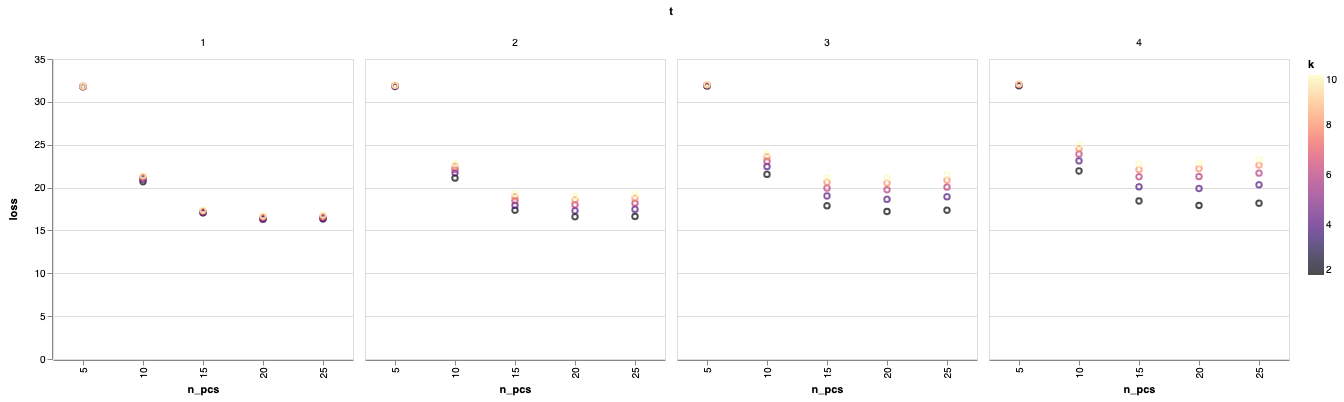

In [15]:
alt.Chart(df).mark_point().encode(
    x="n_pcs:N", y="loss:Q", color=alt.Color('k:Q', scale=alt.Scale(scheme='magma'))
).properties(
    width=300, height=300
).facet(
    column='t:N'
)

The best-performing hyperparameters for MAGIC:

In [16]:
opt_idx = df['loss'].idxmin()

opt_denoised = results[opt_idx][-1]
opt_denoised = np.maximum(opt_denoised, 0)

In [17]:
df.loc[opt_idx][['k', 'n_pcs','t','loss']]

k         4.000000
n_pcs    20.000000
t         1.000000
loss     16.309356
Name: 64, dtype: float64

Compare to PCA

In [18]:
genes_idx = np.array([data.var_names.get_loc(g) for g in genes])

In [ ]:
max_k = 25

x1_norm = data1.values.copy()
x2_norm = data2.values.copy()

U, S, V = randomized_svd(x1_norm, n_components=50, random_state=42)

ss_loss = []
k_range = np.arange(1, max_k)
for k in k_range:
    x_pred = U[:,:k].dot(np.diag(S[:k])).dot(V[:k,genes_idx])
    ss_loss.append(mse(x_pred, x2_norm[:, genes_idx]))

k_opt = k_range[np.argmin(ss_loss)]
x_opt = U[:,:k_opt].dot(np.diag(S[:k_opt])).dot(V[:k_opt,genes_idx])
print("Optimal number of PCs: ", k_opt)

print("PCA loss: ", min(ss_loss)*3)
print("MAGIC opt loss: ", df['loss'].min())
print("MAGIC default loss: ", np.sum(mse(default_denoised[genes], data2[genes])))

## Plot

In [86]:

def plot_df(denoised, title, xticks, yticks, cbar_ticks = None):
    fig,ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [10, 1]})

    cmap = plt.get_cmap('magma')
    norm = plt.Normalize(denoised[genes[2]].min(), denoised[genes[2]].max())

    ax[0].scatter(
        denoised[genes[0]], denoised[genes[1]], 
        c = denoised[genes[2]],
        cmap=cmap, 
        norm=norm,
        alpha=0.5
    )

    ax[0].set_xlabel(genes[0])
    ax[0].set_ylabel(genes[1])

    ax[0].set_xticks(xticks)
    ax[0].set_xticklabels([])
    
    ax[0].set_yticks(yticks)
    ax[0].set_yticklabels([])

    x_marg = np.ptp(xticks) / 20
    y_marg = np.ptp(yticks) / 20
    
#     print(-x_marg, xticks[-1] + x_marg, ax[0].get_xlim())
#     print(-y_marg, yticks[-1] + y_marg, ax[0].get_ylim())
    ax[0].set_xlim(-x_marg, None)
    ax[0].set_ylim(-y_marg, None)
    ax[0].margins(0.05)
    ax[0].autoscale_view()
    ax[0].set_title(title)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    plt.colorbar(
        sm,
        cax=ax[1], 
        label=genes[2],
        ticks=cbar_ticks
    )

In [108]:

def plot_dfs(dfs, titles, xticks, yticks, cbar_ticks):
    fig,ax = plt.subplots(
        len(dfs), 2,
        sharex=False,
        sharey=False,
        figsize=(8, 18),
        gridspec_kw={'width_ratios': [10, 1]},
    )

    cmap = plt.get_cmap('magma')
    for i,df in enumerate(dfs):
        norm = plt.Normalize(df[genes[2]].min(), df[genes[2]].max())

        ax[i,0].scatter(
            df[genes[0]], df[genes[1]], 
            c = df[genes[2]],
            cmap=cmap, 
            norm=norm,
            alpha=0.5
        )

        ax[i,0].set_xlabel(genes[0])
        ax[i,0].set_ylabel(genes[1])

        ax[i,0].set_xticks(xticks[i])
#         ax[i,0].set_xticklabels([])

        ax[i,0].set_yticks(yticks[i])
#         ax[i,0].set_yticklabels([])

        x_marg = np.ptp(xticks[i]) / 20
        y_marg = np.ptp(yticks[i]) / 20

    #     print(-x_marg, xticks[-1] + x_marg, ax[0].get_xlim())
    #     print(-y_marg, yticks[-1] + y_marg, ax[0].get_ylim())
        ax[i,0].set_xlim(-x_marg, None)
        ax[i,0].set_ylim(-y_marg, None)
        ax[i,0].margins(0.05)
        ax[i,0].autoscale_view()
        ax[i,0].set_title(titles[i])

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        plt.colorbar(
            sm,
            cax=ax[i,1], 
            label=genes[2],
            ticks=cbar_ticks[i]
        )

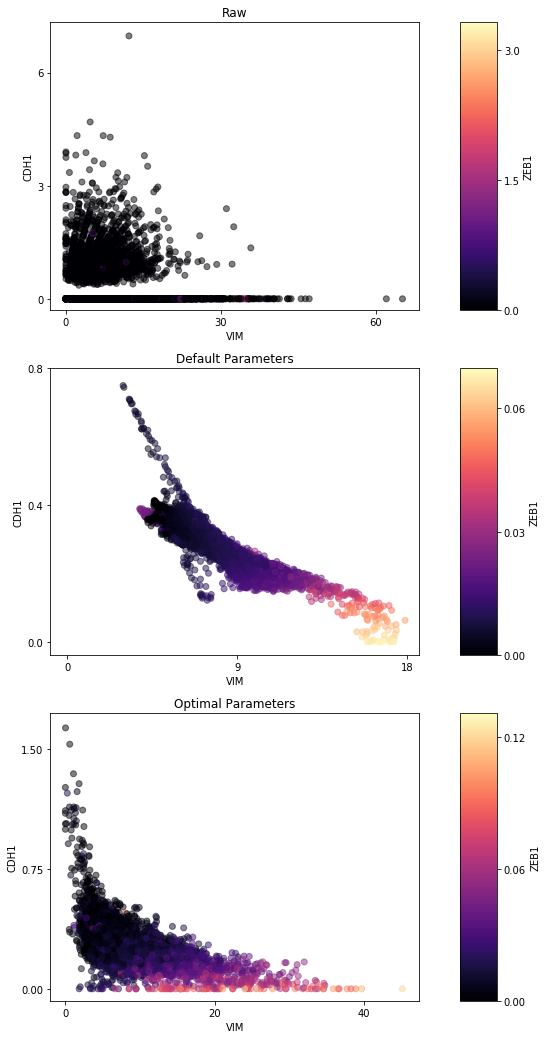

In [109]:

plt.rcParams['svg.fonttype'] = 'none'
plot_dfs(
    [raw, default_denoised, opt_denoised],
    ["Raw", "Default Parameters", "Optimal Parameters"],
    [[0, 30, 60], [0, 9, 18], [0, 20, 40]],
    [[0, 3, 6], [0, 0.4, 0.8], [0, 0.75, 1.5]],
    [[0, 1.5, 3], [0, 0.03, 0.06], [0, 0.06, 0.12]],
)
plt.savefig('../../../magic_figs/magic_all.svg', )

In [99]:
raw = pd.DataFrame(data = x1_norm[:, genes_idx], columns=genes)

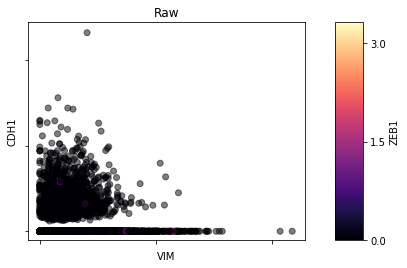

In [89]:
plot_df(
    raw,
    "Raw",
    xticks=[0, 30, 60],
    yticks=[0, 3, 6],
    cbar_ticks = [0, 1.5, 3]
)

plt.savefig('../../../magic_figs/magic_raw.svg')

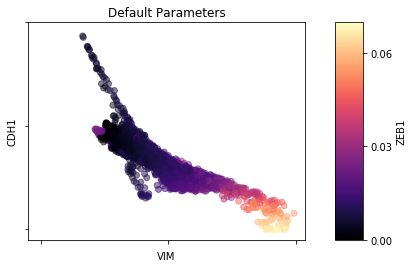

In [87]:
plot_df(
    default_denoised,
    "Default Parameters",
    xticks = [0, 9, 18],
    yticks = [0.0, 0.4, 0.8],
    cbar_ticks = [0, 0.03, 0.06]
)
plt.savefig('../../../magic_figs/magic_default.svg')

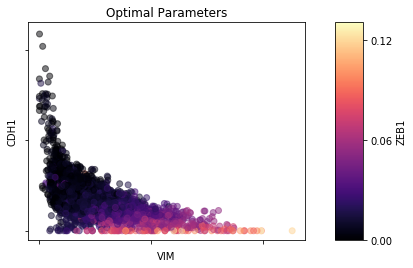

In [88]:
plot_df(
    opt_denoised, 
    "Optimal Parameters", 
    xticks = [0, 20, 40],
    yticks = [0.0, 0.75, 1.5],
    cbar_ticks = [0, 0.06, 0.12],
)
plt.savefig('../../../magic_figs/magic_optimal.svg')